In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
import time
import math
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/vae_cifar10')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
# Hyper-parameters 
input_size = 32*32 # 32x32
hidden_dim = 16
latent_dim = 50 
num_classes = 10
num_epochs = 3
batch_size = 200
learning_rate = 1e-3

In [14]:
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
inv_normalize = transforms.Normalize((-0.5/0.5, -0.5/0.5, -0.5/0.5), (1/0.5, 1/0.5, 1/0.5))


# CIFAR10 Data: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data/cifar10', train=True,
                                                download=True, transform=cifar_transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data/cifar10', train=False,
                                                download=True, transform=cifar_transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


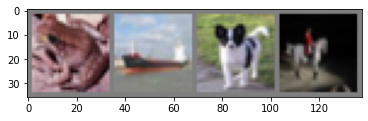

In [4]:
# Visualise sample of images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images[:4])

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(img_grid)

# write to tensorboard
writer.add_image('four_cifar10_images', inv_normalize(img_grid))

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_channels, feature_dim=32*32, hidden_dim=hidden_dim, latent_dim=latent_dim) -> None:
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.conv1 = nn.Conv2d(input_channels, hidden_dim, kernel_size=3, padding=1) # set padding 1 for feature_dim == image_size
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.fc_mu = nn.Linear(hidden_dim*feature_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim*feature_dim, latent_dim)
    
    def forward(self, x): # x = [batch_size, input_channels, 32, 32]
        x = F.relu(self.conv1(x))  # (input width - filter size + 2*padding)/stride + 1 : (32 - 3 + 2) + 1 = 32
        x = F.relu(self.conv2(x))  # x.shape = [batch, n_filters, 32, 32]
        x = x.view(-1, self.hidden_dim*32*32)
        self.mu = self.fc_mu(x)
        self.logvar = self.fc_logvar(x)
        return self.mu, self.logvar


In [6]:
class Decoder(nn.Module):
    def __init__(self, input_channels, feature_dim=32*32, hidden_dim=hidden_dim, latent_dim=latent_dim) -> None:
        super(Decoder, self).__init__()
        self.fc_z = nn.Linear(latent_dim, hidden_dim*feature_dim)
        self.deconv1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(hidden_dim, input_channels, kernel_size=3, padding=1)

    def forward(self, z): # z.shape : [batch_size, latent_dim]
        x_hat = F.relu(self.fc_z(z))
        x_hat = x_hat.view(-1, hidden_dim, 32, 32)
        x_hat = F.relu(self.deconv1(x_hat))
        x_hat = torch.tanh(self.deconv2(x_hat))
        return x_hat
    

In [7]:
class VAE(nn.Module):
    def __init__(self) -> None:
        super(VAE, self).__init__()
        self.encoder = Enco

    def forward(self, x):
        pass

In [8]:
def loss_function(x, x_hat, mu, logvar):
    reproduction_loss = F.mse_loss(x_hat, x, reduction="sum")
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reproduction_loss - kl_divergence


In [9]:
n_training_samples = len(train_dataset) # 50000
n_iterations = math.ceil(n_training_samples/batch_size)

encoder = Encoder(input_channels=3)
decoder = Decoder(input_channels=3)
optimiser = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)
for epoch in range(num_epochs):
    overall_loss = 0
    for i, (image, label) in enumerate(train_loader):
        #image shape 4, 3, 32, 32 -> 4, 3, 1024

        optimiser.zero_grad()

        # Inference
        mu, logvar = encoder(image)

        # Reparametrisation
        std = torch.exp(logvar/2)
        epsilon = torch.randn_like(std) # generate eps [0,1) with dim matching std
        z = mu + std * epsilon

        # Generate
        x_hat = decoder(z)

        # Loss
        loss = loss_function(image, x_hat, mu, logvar)

        overall_loss += loss

        # Update weights
        loss.backward()
        optimiser.step()

        if (i+1) % 50 == 0:
            #print(f"epoch: {epoch+1}/{num_epochs}, step: {i+1}/{n_iterations}, image: {image.shape}")
            print(f"epoch: {epoch+1}/{num_epochs}, step: {i+1}/{n_iterations}, Avg loss: {overall_loss/(i*batch_size):.5f}")

epoch: 0/3, step: 50/250, Avg loss: 607.38251
epoch: 0/3, step: 100/250, Avg loss: 485.46802
epoch: 0/3, step: 150/250, Avg loss: 426.74530
epoch: 0/3, step: 200/250, Avg loss: 387.40564
epoch: 0/3, step: 250/250, Avg loss: 360.55450
epoch: 1/3, step: 50/250, Avg loss: 245.39265
epoch: 1/3, step: 100/250, Avg loss: 239.72035
epoch: 1/3, step: 150/250, Avg loss: 234.86168
epoch: 1/3, step: 200/250, Avg loss: 232.28737
epoch: 1/3, step: 250/250, Avg loss: 229.97081
epoch: 2/3, step: 50/250, Avg loss: 221.85107
epoch: 2/3, step: 100/250, Avg loss: 219.08871
epoch: 2/3, step: 150/250, Avg loss: 218.12605
epoch: 2/3, step: 200/250, Avg loss: 217.10530
epoch: 2/3, step: 250/250, Avg loss: 216.43410


In [38]:
encoder.eval()
decoder.eval()
def make_image_grids():
    with torch.no_grad():

        # Visualise sample of images
        dataiter = iter(test_loader)
        images, _ = dataiter.next()

        # Inference
        mu, logvar = encoder(images)

        # Reparametrisation
        std = torch.exp(logvar/2)
        epsilon = torch.randn_like(std) # generate eps [0,1) with dim matching std
        z = mu + std * epsilon

        # Generate
        x_hat = decoder(z)

        # create grid of images
        img_grid = torchvision.utils.make_grid(images[:4])
        x_hat_grid =  torchvision.utils.make_grid(x_hat[:4])
        
        return img_grid, x_hat_grid
    

In [45]:
def stats(x):
    return x.mean(), x.std()
stats(images[0][0].view(-1)), stats(x_hat[0][0].view(-1))

((tensor(0.1011), tensor(0.3762)),
 (tensor(-0.1605, grad_fn=<MeanBackward0>),
  tensor(0.1902, grad_fn=<StdBackward0>)))

In [24]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

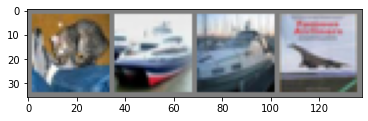

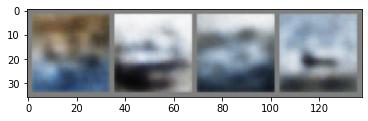

In [39]:
img_grid, x_hat_grid = make_image_grids()
# show images
imshow(img_grid)
imshow(x_hat_grid)

# write to tensorboard
# writer.add_image('four_cifar10_images', inv_normalize(img_grid))